In [1]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d vuppalaadithyasairam/bone-fracture-detection-using-xrays

 84% 145M/172M [00:01<00:00, 82.4MB/s]
100% 172M/172M [00:01<00:00, 111MB/s] 


In [4]:
!unzip bone-fracture-detection-using-xrays.zip

Streaming output truncated to the last 5000 lines.
  inflating: archive (6)/train/fractured/99-rotated2-rotated3.jpg  
  inflating: archive (6)/train/fractured/99-rotated2.jpg  
  inflating: archive (6)/train/fractured/99-rotated3-rotated1-rotated1.jpg  
  inflating: archive (6)/train/fractured/99-rotated3-rotated1-rotated2.jpg  
  inflating: archive (6)/train/fractured/99-rotated3-rotated1-rotated3.jpg  
  inflating: archive (6)/train/fractured/99-rotated3-rotated1.jpg  
  inflating: archive (6)/train/fractured/99-rotated3-rotated2-rotated1.jpg  
  inflating: archive (6)/train/fractured/99-rotated3-rotated2-rotated2.jpg  
  inflating: archive (6)/train/fractured/99-rotated3-rotated2-rotated3.jpg  
  inflating: archive (6)/train/fractured/99-rotated3-rotated2.jpg  
  inflating: archive (6)/train/fractured/99-rotated3-rotated3-rotated1.jpg  
  inflating: archive (6)/train/fractured/99-rotated3-rotated3-rotated2.jpg  
  inflating: archive (6)/train/fractured/99-rotated3-rotated3-rotated3

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [5]:
from keras.src.preprocessing.image import validate_filename
from keras.preprocessing.image import ImageDataGenerator

path = '/content/archive (6)'

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale = 1./255)

train = train_datagen.flow_from_directory(path + '/train',
                                          target_size = (128, 128),
                                          batch_size = 32,
                                          class_mode = 'binary')

val = val_datagen.flow_from_directory(path + '/val',
                                      target_size = (128, 128),
                                      batch_size = 32,
                                      class_mode = 'binary')


Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [20]:
val.class_indices

{'fractured': 0, 'not fractured': 1}

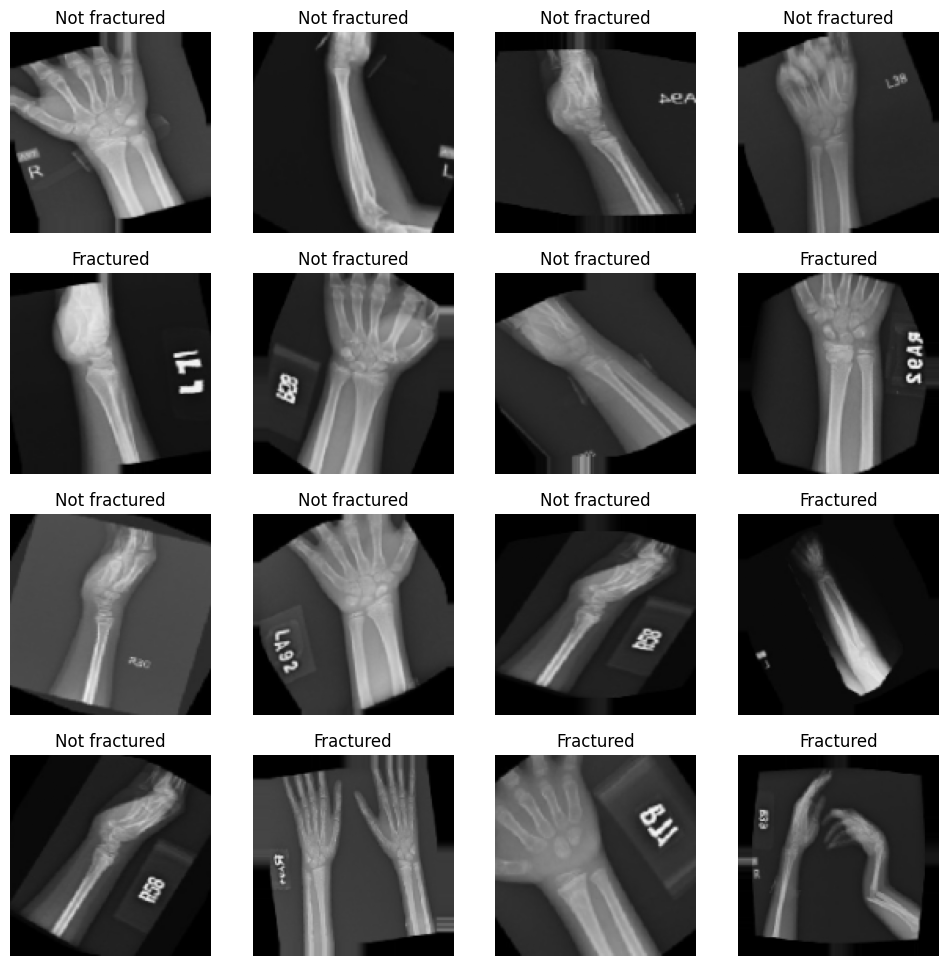

In [12]:
def plot_images(img, label):
    plt.figure(figsize=[12, 12])
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if label[i] == 0:
            plt.title("Fractured")
        else:
            plt.title("Not fractured")

img,lbl = next(train)
plot_images(img,lbl)

In [6]:
from keras.applications import DenseNet121
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Sequential

densenet = DenseNet121(weights = None, include_top = False, input_shape = (128, 128, 3))


model = Sequential()
model.add(densenet)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy']
                )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 7562817 (28.85 MB)
Trainable params: 7479169 (28.53 MB)
Non-trainable params: 83648 (326.75 KB)
____________

In [7]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss',
                             patience=8,
                             restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath='model.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.4,
                              patience=3)


history = model.fit(train,
                    validation_data=val,
                    callbacks=[checkpoint, early_stopping, reduce_lr],
                    epochs=20
                   )

Epoch 1/20
277/277 [==============================] - 152s 255ms/step - loss: 0.5969 - accuracy: 0.6825 - val_loss: 1.0283 - val_accuracy: 0.5867 - lr: 0.0010
Epoch 2/20
277/277 [==============================] - 62s 225ms/step - loss: 0.4723 - accuracy: 0.7740 - val_loss: 1.9596 - val_accuracy: 0.5033 - lr: 0.0010
Epoch 3/20
277/277 [==============================] - 63s 227ms/step - loss: 0.3693 - accuracy: 0.8382 - val_loss: 0.8833 - val_accuracy: 0.5433 - lr: 0.0010
Epoch 4/20
277/277 [==============================] - 63s 227ms/step - loss: 0.2595 - accuracy: 0.8979 - val_loss: 0.7671 - val_accuracy: 0.7533 - lr: 0.0010
Epoch 5/20
277/277 [==============================] - 63s 226ms/step - loss: 0.1960 - accuracy: 0.9234 - val_loss: 0.5503 - val_accuracy: 0.7850 - lr: 0.0010
Epoch 6/20
277/277 [==============================] - 62s 225ms/step - loss: 0.1622 - accuracy: 0.9394 - val_loss: 7.9753 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 7/20
277/277 [==============================]

In [8]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model_weights.h5")

In [9]:
import pandas as pd

history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)

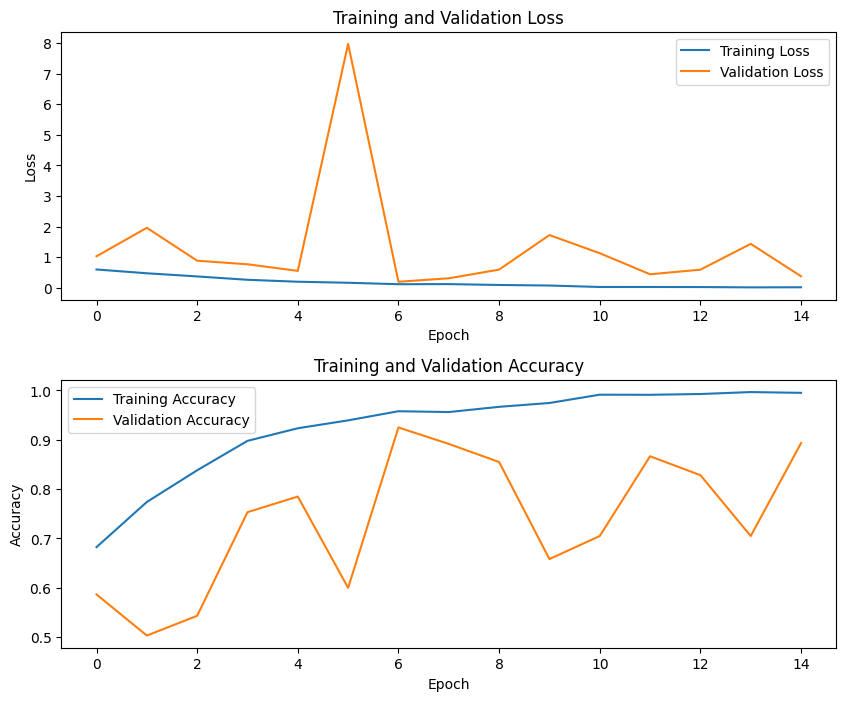

In [13]:
loaded_history = pd.read_csv('training_history.csv')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(loaded_history['loss'], label='Training Loss')
ax1.plot(loaded_history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Training and Validation Loss')
ax1.grid(False)

ax2.plot(loaded_history['accuracy'], label='Training Accuracy')
ax2.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_title('Training and Validation Accuracy')
ax2.grid(False)
plt.subplots_adjust(hspace=0.3)
plt.savefig('training_metrics_plot.png')

plt.show()

In [11]:
accu = model.evaluate(val)[1]
print('Final Test Acccuracy = {:.3f}'.format(accu*100))

19/19 [==============================] - 1s 57ms/step - loss: 0.1941 - accuracy: 0.9250
Final Test Acccuracy = 92.500


19/19 [==============================] - 2s 95ms/step


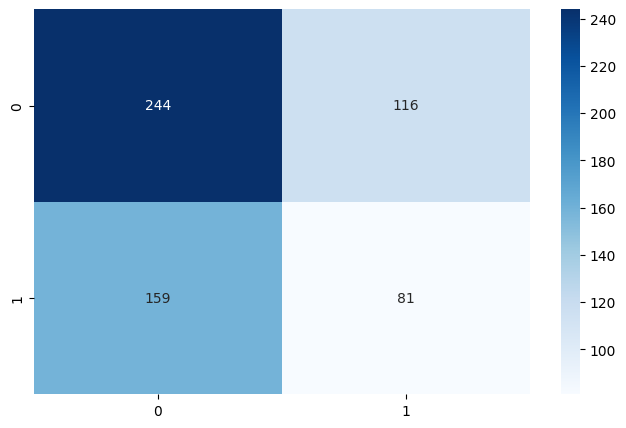

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(val)

plt.figure(figsize = (8,5))
sns.heatmap(confusion_matrix(val.classes, y_pred.round()), annot = True,fmt="d",cmap = "Blues")
plt.show()

In [19]:
report = classification_report(val.classes, y_pred.round())
print('\nClassification Report')
print(report)


Classification Report
              precision    recall  f1-score   support

           0       0.61      0.68      0.64       360
           1       0.41      0.34      0.37       240

    accuracy                           0.54       600
   macro avg       0.51      0.51      0.51       600
weighted avg       0.53      0.54      0.53       600

